In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    recall_score, f1_score, roc_auc_score,
    precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay
)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.cluster import MiniBatchKMeans

In [18]:
# Load and split data
data = pd.read_csv('../data/processed/fraud.csv')
X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P'].astype(int)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 9252, Val: 3084, Test: 3084


In [19]:
# Define resampling methods
kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)

resamplers = {
    "SMOTE": SMOTE(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42),
    "SMOTETomek": SMOTETomek(random_state=42),
    "KMeansSMOTE": KMeansSMOTE(
        random_state=42, kmeans_estimator=kmeans, cluster_balance_threshold=0.01
    )
}

In [20]:
# Define evaluation helper
def evaluate_pipeline(name, pipeline, X_train, y_train, X_val, y_val):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    y_prob = pipeline.predict_proba(X_val)[:, 1]

    precision, recall_curve, _ = precision_recall_curve(y_val, y_prob)

    return {
        "Recall": recall_score(y_val, y_pred),
        "F1-score": f1_score(y_val, y_pred),
        "ROC-AUC": roc_auc_score(y_val, y_prob),
        "PR-AUC": auc(recall_curve, precision)
    }

In [21]:
# Train & Evaluate Pipelines
results = {}
pipelines = {}

for name, sampler in resamplers.items():
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    pipe = Pipeline(steps=[("resample", sampler), ("model", clf)])
    pipelines[name] = pipe
    results[name] = evaluate_pipeline(name, pipe, X_train, y_train, X_val, y_val)

results_df = pd.DataFrame(results).T
print("\n=== Validation Results ===")
print(results_df)


=== Validation Results ===
               Recall  F1-score   ROC-AUC    PR-AUC
SMOTE        0.086957  0.135593  0.804500  0.188461
SMOTEENN     0.222826  0.227147  0.802436  0.173195
SMOTETomek   0.065217  0.106195  0.801588  0.182085
KMeansSMOTE  0.065217  0.114286  0.858400  0.262743


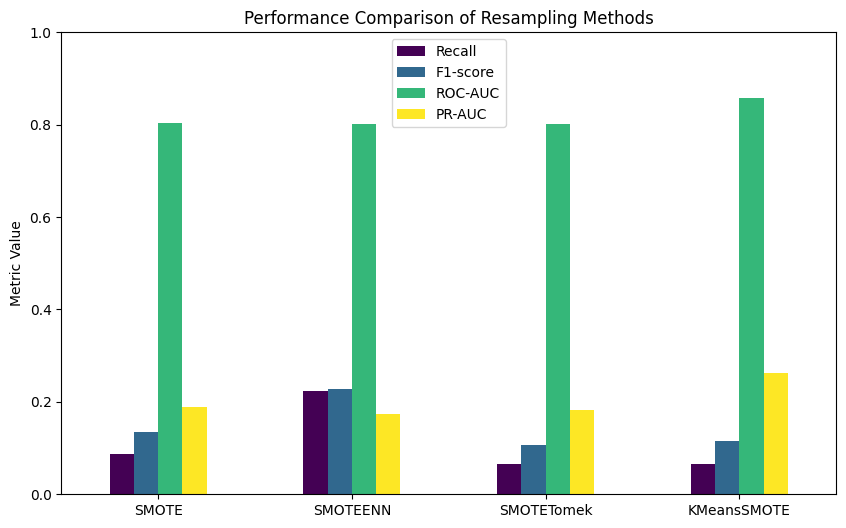

In [22]:
# Visualize performance
results_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Performance Comparison of Resampling Methods")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()

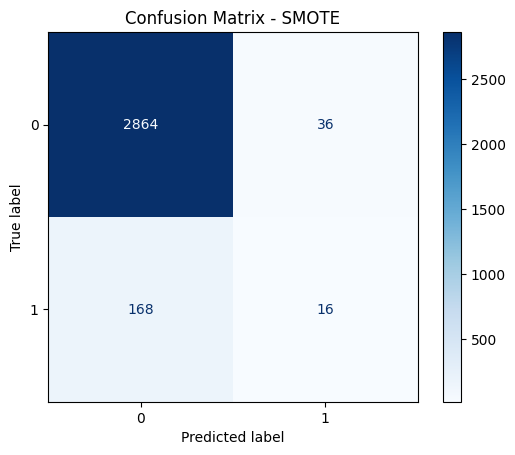

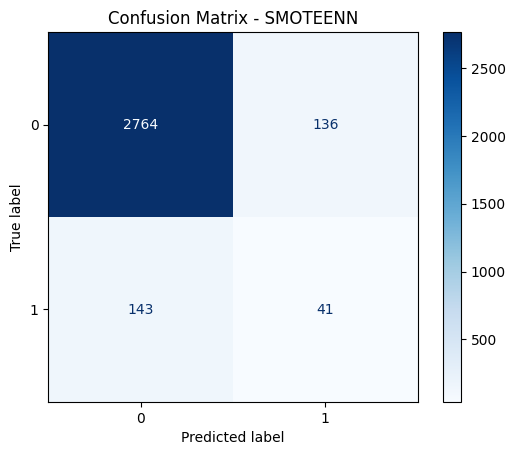

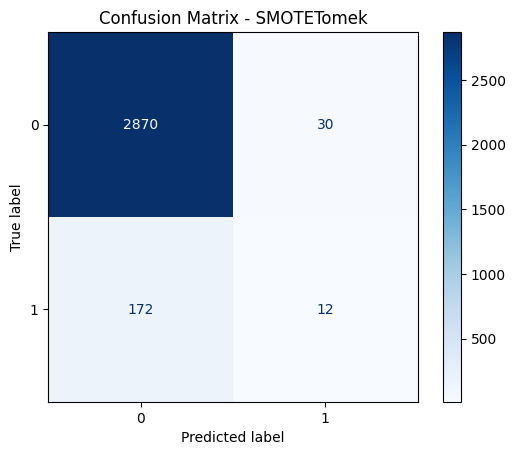

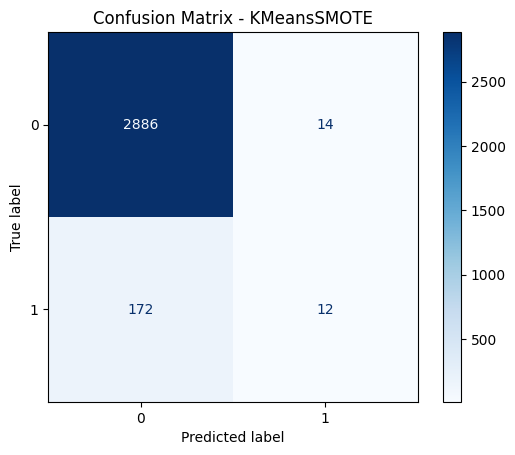

In [23]:
# Confusion Matrices
for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [24]:
# Cross-validation F1 stability check
cv_results = {}
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1')
    cv_results[name] = {"F1-mean": scores.mean(), "F1-std": scores.std()}

cv_df = pd.DataFrame(cv_results).T
print("\n=== Cross-validation Results ===")
print(cv_df)



=== Cross-validation Results ===
              F1-mean    F1-std
SMOTE        0.054015  0.016100
SMOTEENN     0.160108  0.023939
SMOTETomek   0.046617  0.010718
KMeansSMOTE  0.070169  0.028280
